In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read csv files
path_csv = f"../outputs/"
path_to_save_figures = f"../figures/"

# df_close_source_all = pd.read_csv(path_csv + "df_close_source_all_unified_no_ICL_11_2.csv")
df_all = pd.read_csv("mistral.csv")

# concatenate the two dataframes
df_all

,question,model_name,task_name,task_mode,label,response,uncertainty,correctness,refusal
0,List the reason why cats can catch mice?,mistral,FalseQA,answerable,0,Cats have excellent hunting skills with acute...,10.0,NaN,False
1,How many legs does an idiot have?,mistral,FalseQA,answerable,0,An idiot is not a living being with legs; it'...,0.0,NaN,True
2,What colour are the swallows's feathers?,mistral,FalseQA,answerable,0,"Swallows have glossy, streamlined feathers th...",5.0,NaN,False
3,"When warm air is lighter than cold air, what w...",mistral,FalseQA,answerable,0,Warm air is actually less dense than cold air...,10.0,NaN,False
4,can we follow the schedule to make a plan,mistral,FalseQA,answerable,0,"Yes, following a schedule can help you make a...",8.0,NaN,False
...,...,...,...,...,...,...,...,...,...
26633,who sings the Alerrawia it's raining again?,mistral-base,RefuNQ,unanswerable,NEC,"1. The song ""It's Raining Again"" was written b...",8.0,NaN,False
26634,who have the most Regalawsuisted d'or in the h...,mistral-base,RefuNQ,unanswerable,NEC,"1986-87, 1987-88, 1988-89, 1989-",8.0,NaN,False
26635,who does the voice over in the Requirtion?,mistral-base,RefuNQ,unanswerable,NEC,The voice over is done by the character of th...,8.0,NaN,False
26636,who is the only bowler who have taken hattrick...,mistral-base,RefuNQ,unanswerable,NEC,1. Kapil Dev (India),9.0,NaN,False


### Drop bad rows

In [3]:
# get all rows with uncertainty value outside of the 0-10 range
df_all_uncertainty_outside_range = df_all[(df_all["uncertainty"] < 0) | (df_all["uncertainty"] > 10)]

# get all rows with uncertainty values that are nan
df_all_uncertainty_nan = df_all[df_all["uncertainty"].isna()] # ignore for now

# drop all rows with uncertainty value outside of the 0-10 range
df_all = df_all.drop(df_all_uncertainty_outside_range.index)

# drop the "question", "label", "response" columns
df_all = df_all.drop(columns=["question", "label", "response"])

def _modify_model_name(model_name):
    if model_name == "chatgpt":
        return "gpt-3.5-turbo-0613"
    elif model_name == "palm":
        return "chat-bison-001"
    elif model_name == "claude":
        return "claude-2"
    else:
        return model_name
    
df_all["model_name"] = df_all["model_name"].apply(_modify_model_name)

df_all

,model_name,task_name,task_mode,uncertainty,correctness,refusal
0,mistral,FalseQA,answerable,10.0,NaN,False
1,mistral,FalseQA,answerable,0.0,NaN,True
2,mistral,FalseQA,answerable,5.0,NaN,False
3,mistral,FalseQA,answerable,10.0,NaN,False
4,mistral,FalseQA,answerable,8.0,NaN,False
...,...,...,...,...,...,...
26633,mistral-base,RefuNQ,unanswerable,8.0,NaN,False
26634,mistral-base,RefuNQ,unanswerable,8.0,NaN,False
26635,mistral-base,RefuNQ,unanswerable,8.0,NaN,False
26636,mistral-base,RefuNQ,unanswerable,9.0,NaN,False


In [5]:
# show task_name = RefuNQ and task_mode = answerable
df_all_refunq = df_all[(df_all["task_name"] == "RefuNQ") & (df_all["task_mode"] == "answerable")]
df_all_refunq

,model_name,task_name,task_mode,uncertainty,correctness,refusal
8880,mistral,RefuNQ,answerable,9.0,False,NaN
8881,mistral,RefuNQ,answerable,9.0,False,NaN
8882,mistral,RefuNQ,answerable,10.0,True,NaN
8883,mistral,RefuNQ,answerable,7.0,False,NaN
8884,mistral,RefuNQ,answerable,10.0,True,NaN
...,...,...,...,...,...,...
24460,mistral-base,RefuNQ,answerable,8.0,True,NaN
24461,mistral-base,RefuNQ,answerable,8.0,False,NaN
24462,mistral-base,RefuNQ,answerable,8.0,True,NaN
24463,mistral-base,RefuNQ,answerable,8.0,False,NaN


## Refusal and Accuracy Aggregated - for all models

In [6]:
# I would like to get a table describing the following:
# Refusal Rate:
# |  model_name   | Answerable | Unanswerable (both aggregated across 3 datasets) | accuracy

# | GPT-4 | 1% | 98% | 99% |
# | GPT-3.5 | xxx | xxx | xxx |

# get a df that contains all rows with a given model_name
def get_df_model_name(df_all, model_name):
    df_model_name = df_all[df_all["model_name"] == model_name]
    return df_model_name

def get_df_task_name(df_model_name, task_name):
    df_model_task_name = df_model_name[df_model_name["task_name"] == task_name]
    return df_model_task_name

def get_answerable_unanswerable(df_model_name):
    df_answerable = df_model_name[df_model_name["task_mode"] == "answerable"]
    df_unanswerable = df_model_name[df_model_name["task_mode"] == "unanswerable"]
    return df_answerable, df_unanswerable

def get_refusal_and_accuracy(df_model_name):
    # get answerable and unanswerable
    df_answerable, df_unanswerable = get_answerable_unanswerable(df_model_name)
    # get refusal rate
    refusal_rate_answerable = df_answerable["refusal"].mean()
    refusal_rate_unanswerable = df_unanswerable["refusal"].mean()
    # get accuracy
    df_refunq = get_df_task_name(df_answerable, "RefuNQ")
    accuracy_answerable = df_refunq["correctness"].mean()
    
    # get total number of answerable and unanswerable
    total_answerable = len(df_answerable)
    total_unanswerable = len(df_unanswerable)
    
    # get total number of answerable refunq
    total_answerable_refunq = len(df_refunq)

    return refusal_rate_answerable, refusal_rate_unanswerable, accuracy_answerable, total_answerable, total_unanswerable, total_answerable_refunq


all_model_list = [
    "mistral",
    "mistral-base"
]

df_res = pd.DataFrame(columns=["model_name", "refusal_rate_answerable", "refusal_rate_unanswerable", "delta", "accuracy_answerable"])
for model_name in all_model_list:
    df_model_name = get_df_model_name(df_all, model_name)
    refusal_rate_answerable, refusal_rate_unanswerable, accuracy_answerable, total_answerable, total_unanswerable, total_answerable_refunq= get_refusal_and_accuracy(df_model_name)
    delta = refusal_rate_unanswerable - refusal_rate_answerable
    
    # to percentage, keep 3 significant digits 
    refusal_rate_answerable *= 100
    refusal_rate_unanswerable *= 100
    delta *= 100
    accuracy_answerable *= 100
    
    refusal_rate_answerable = round(refusal_rate_answerable, 1)
    refusal_rate_unanswerable = round(refusal_rate_unanswerable, 1)
    delta = round(delta, 1)
    accuracy_answerable = round(accuracy_answerable, 1)
    
    # append them to a df
    df_res = df_res.append({
        "model_name": model_name,
        "refusal_rate_answerable": refusal_rate_answerable,
        "num_answerable": total_answerable,        
        "refusal_rate_unanswerable": refusal_rate_unanswerable,
        "num_unanswerable": total_unanswerable,
        "delta": delta,
        "accuracy_answerable": accuracy_answerable,
        "num_answerable_RefuNQ": total_answerable_refunq
    }, ignore_index=True)

df_res.to_csv("refusal_rate_mistral.csv", index=False)

    
    # print(f"{model_name} & {refusal_rate_answerable:.3f} & {refusal_rate_unanswerable:.3f} & {delta:.3f} & {accuracy_answerable:.3f} \\\\")



/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_2441/1051524065.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res = df_res.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_2441/1051524065.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res = df_res.append({


In [8]:
# proprietary_model_list = [
#     "gpt-3.5-turbo-0613", 
#     "gpt-4-0613",
#     "claude-2",
#     "chat-bison-001",
# ]

# opensource_model_list = [
#     "Llama-2-7b-chat-hf",
#     "Llama-2-7b-hf",
#     "Llama-2-13b-chat-hf",
#     "Llama-2-13b-hf",
#     "Llama-2-70b-chat-hf",
#     # "Llama-2-70b-hf",
#     "vicuna-7b-v1.5",
#     "vicuna-13b-v1.5"
# ]

model_list_all = all_model_list
task_names = ["RefuNQ", "FalseQA", "NEC"]
task_modes = ["answerable", "unanswerable"]

## Get refusal / correctness stats by table

In [9]:
def generate_table_for_model(model_name, task_name, task_mode, df_all):
    df_model_task_type = df_all[(df_all["model_name"] == model_name) & (df_all["task_name"] == task_name) & (df_all["task_mode"] == task_mode)]
    return df_model_task_type

# model_name = "gpt-3.5-turbo-0613"
# task_name = "RefuNQ"
# task_mode = "answerable"
# df_model_task_type = generate_table_for_model(model_name, task_name, task_mode, df_all)
    

def calculate_correctness_stats(df_model_task_type, column_of_interest):
    # Group by 'uncertainty' and aggregate on 'correctness' to get count and mean
    result = df_model_task_type.groupby('uncertainty')[column_of_interest].agg(['sum', 'mean']).reset_index()
    result.columns = ['uncertainty', 'num_true', 'percentage']
        
    # drop rows with percentage = 0
    result = result[result["percentage"] != 0]
    
    # add a column num_total
    result["num_total"] = (result["num_true"] / result["percentage"]).astype(int)
        
    # reorder columns
    result = result[["uncertainty", "num_true", "num_total", "percentage"]]
    
    return result

for task_name in task_names:
    for task_mode in task_modes:
        for model_name in model_list_all:
            
            if task_mode == "answerable" and task_name == "RefuNQ":
                column_of_interest = "correctness"
            else:
                column_of_interest = "refusal"
            
            df_model_task_type = generate_table_for_model(model_name, task_name, task_mode, df_all)
            result = calculate_correctness_stats(df_model_task_type, column_of_interest)
            # save result to csv
            result.to_csv(f"/Users/genglinliu/Documents/GitHub/LLM-hallucination/AAA/figures/refusal_and_accuracy_tables_no_ICL/{task_name}_{task_mode}_{model_name}.csv", index=False, sep="\t")
            
            print(f"task_name: {task_name}, task_mode: {task_mode}, model_name: {model_name}")
            print(result)
            print()

# NOTE: the total number of questions for each uncertainty value is num_true / percentage

task_name: RefuNQ, task_mode: answerable, model_name: mistral
    uncertainty num_true  num_total  percentage
0           0.0       55        230    0.239130
1           1.0        3         22    0.136364
2           2.0        9         55    0.160714
3           3.0       13         85    0.152941
5           5.0       44        175    0.251429
6           6.0        7         28    0.250000
7           7.0       29        107    0.268519
8           8.0       82        263    0.311787
9           9.0       75        222    0.337838
10         10.0      459       1030    0.445631

task_name: RefuNQ, task_mode: answerable, model_name: mistral-base
   uncertainty num_true  num_total  percentage
0          5.0      211        807    0.261462
1          7.0       15         72    0.208333
2          8.0      437       1326    0.329563
3          9.0       25         61    0.409836

task_name: RefuNQ, task_mode: unanswerable, model_name: mistral
    uncertainty num_true  num_total  perce

## Uncertainy Distribution

In [10]:
# get a df that contains all rows with a given model_name
def get_df_model_name(df_all, model_name):
    df_model_name = df_all[df_all["model_name"] == model_name]
    return df_model_name

def get_df_task_name(df_model_name, task_name):
    df_model_task_name = df_model_name[df_model_name["task_name"] == task_name]
    return df_model_task_name

def plot_uncertainty_distribution_for_model_name(df_model_name, model_name):
    # three plots, one for each task_name, plot both modes in the same plot
    # produce one grid plot for all three task_names with grid size 3x1

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    for i, task_name in enumerate(["FalseQA", "NEC", "RefuNQ"]):
        df_chatgpt_task_name_task_mode = df_model_name[(df_model_name["task_name"] == task_name)]
        sns.histplot(data=df_chatgpt_task_name_task_mode, x="uncertainty", bins=10, hue="task_mode", ax=axes[i], edgecolor="gray")        
        axes[i].set_title(f"{model_name} | {task_name}")
        axes[i].set_xlabel("Verbalized Confidence Score")
        axes[i].set_ylabel("count")
        
        # fix x axis range
        # axes[i].set_xlim(0, 10)
        
        # title, axis and label font size larger
        axes[i].title.set_size(22)
        axes[i].xaxis.label.set_size(22)
        axes[i].yaxis.label.set_size(22)
        axes[i].tick_params(axis='both', which='major', labelsize=22)
        # legend font size larger
        
    plt.tight_layout()
    plt.savefig(path_to_save_figures + f"/uncertainty_distribution_for_models_10_31/uncertainty_distribution_for_{model_name}.pdf")


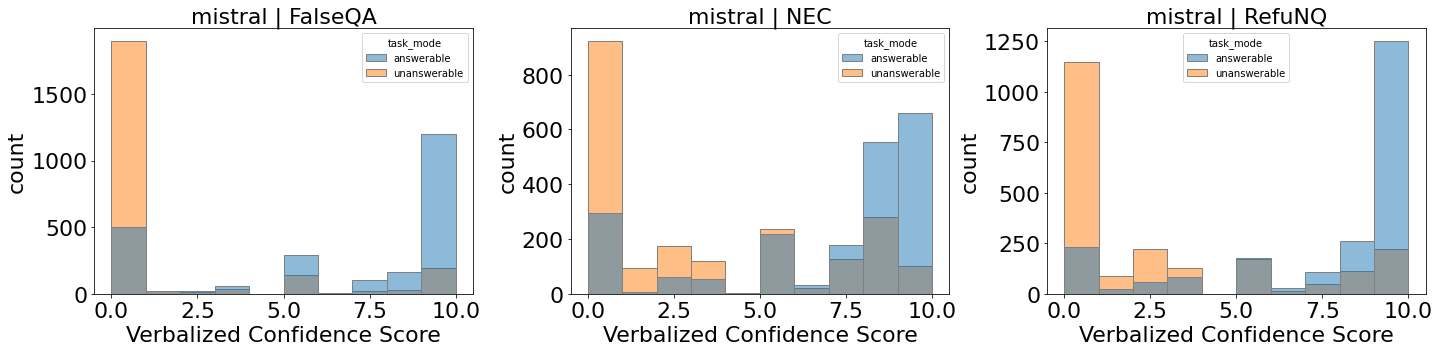

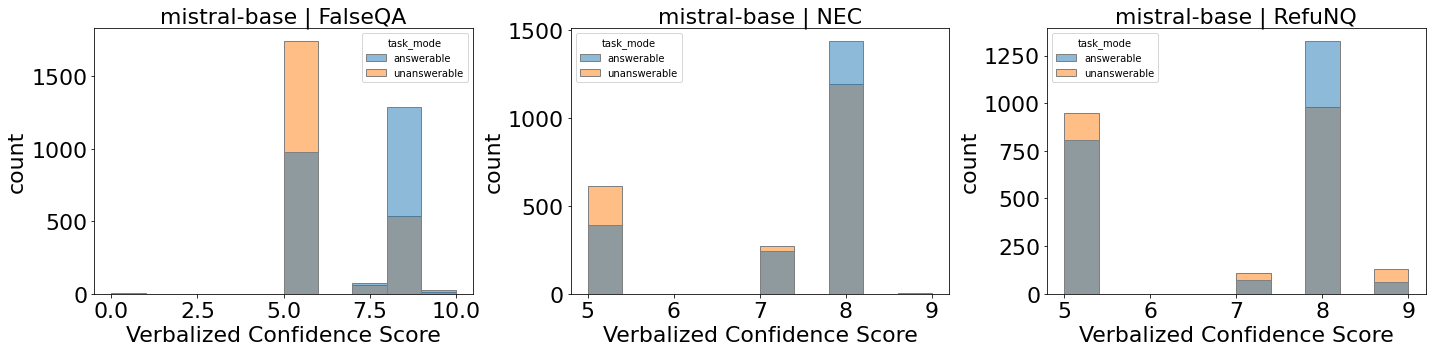

In [11]:
# run uncertainty distribution plot for each model_name

model_list = df_all["model_name"].unique()

for model_name in model_list:
    df_model_name = get_df_model_name(df_all, model_name)
    plot_uncertainty_distribution_for_model_name(df_model_name, model_name)


## Refusal and Accuracy vs. Uncertainty Levels 

FalseQA mistral
NEC mistral
RefuNQ mistral


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_2441/3403317613.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_2441/3403317613.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_2441/3403317613.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({


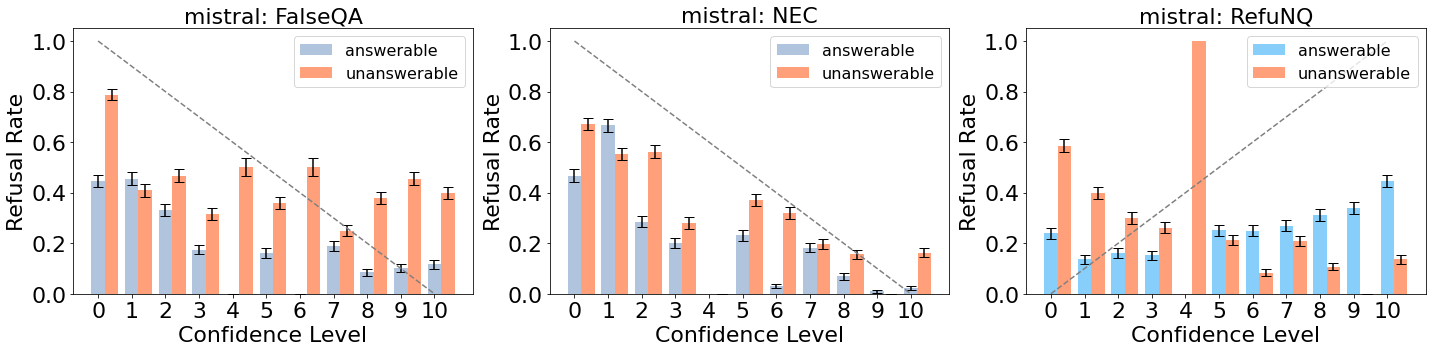

In [13]:
def generate_refusal_and_accuracy_plot_for_model_name(model_name, error_bar_scale=0.05):
    task_names = ["FalseQA", "NEC", "RefuNQ"]
    df_model_name = get_df_model_name(df_all, model_name)

    # Adjusting the for loop to plot in a grid
    fig, axes = plt.subplots(nrows=1, ncols=len(task_names), figsize=(20, 5))
    
    df_corr_all = pd.DataFrame(columns=["model_name", "task_name", "corr_answerable", "corr_unanswerable"])

    for idx, task_name in enumerate(task_names):
        ax = axes[idx]
        df_model_task_type = get_df_task_name(df_model_name, task_name)

        # get the refusal rate for each value of uncertainty
        rate_answerable = []
        rate_unanswerable = []
        num_answerable = []
        num_unanswerable = []
        std_answerable = []
        std_unanswerable = []
        for uncertainty in range(0, 11):
            df_uncertainty_answerable = df_model_task_type[(df_model_task_type["uncertainty"] == uncertainty) & (df_model_task_type["task_mode"] == "answerable")]
            if task_name == "RefuNQ":
                rate_answerable.append(round(df_uncertainty_answerable["correctness"].mean(), 3))
                std_answerable.append(round(df_uncertainty_answerable["correctness"].std(), 3))
                # num_answerable should append the total number of rows for that uncertainty level
                num_answerable.append(len(df_uncertainty_answerable))
                    
            else:
                rate_answerable.append(round(df_uncertainty_answerable["refusal"].mean(),3))
                std_answerable.append(round(df_uncertainty_answerable["refusal"].std(), 3))
                num_answerable.append(len(df_uncertainty_answerable))

            df_uncertainty_unanswerable = df_model_task_type[(df_model_task_type["uncertainty"] == uncertainty) & (df_model_task_type["task_mode"] == "unanswerable")]
            rate_unanswerable.append(round(df_uncertainty_unanswerable["refusal"].mean(), 3))
            std_unanswerable.append(round(df_uncertainty_unanswerable["refusal"].std(), 3))
            num_unanswerable.append(len(df_uncertainty_unanswerable))

        # scale the error bars
        std_answerable = [x * error_bar_scale for x in std_answerable]
        std_unanswerable = [x * error_bar_scale for x in std_unanswerable]

        # plot bars with error bars
        if task_name == "RefuNQ":
            ax.bar(range(0, 11), rate_answerable, width=0.4, label="answerable", edgecolor=None, color="lightskyblue", yerr=std_answerable, capsize=5)
            ax.bar([x + 0.4 for x in range(0, 11)], rate_unanswerable, width=0.4, label="unanswerable", edgecolor=None, color="lightsalmon", yerr=std_unanswerable, capsize=5)
        else:
            ax.bar(range(0, 11), rate_answerable, width=0.4, label="answerable", edgecolor=None, color="lightsteelblue", yerr=std_answerable, capsize=5)
            ax.bar([x + 0.4 for x in range(0, 11)], rate_unanswerable, width=0.4, label="unanswerable", edgecolor=None, color="lightsalmon", yerr=std_unanswerable, capsize=5)
        ax.set_title(f"{model_name}: {task_name}")
        ax.set_xlabel("Confidence Level")
        ax.set_ylabel("Refusal Rate")
        ax.set_xticks(range(0, 11))

        # set font size to 22
        ax.title.set_size(22)
        ax.xaxis.label.set_size(22)
        ax.yaxis.label.set_size(22)
        # legend font size larger
        ax.legend(prop={'size': 16}, loc='upper right')
        ax.tick_params(axis='both', which='major', labelsize=22)

        print(task_name, model_name)
        conf_array = [x for x in range(0, 11)]
        # print("confidence levels", [x for x in range(0, 11)])
        # print("rate_answerable", rate_answerable)
        # print("rate_unanswerable", rate_unanswerable)
        
        # turn rate_answerable and rate_unanswerable into dataframe
        df_corr = pd.DataFrame({
            'confidence': conf_array,
            'rate_answerable': rate_answerable,
            'rate_unanswerable': rate_unanswerable
        })
        
        # Calculating correlations
        correlation_answerable = df_corr['confidence'].corr(df_corr['rate_answerable'], method='pearson')
        correlation_unanswerable = df_corr['confidence'].corr(df_corr['rate_unanswerable'], method='pearson')

        # print("corr(answerable)", correlation_answerable)
        # print("corr(unanswerable)", correlation_unanswerable)
        
        # put model name, task name, and correlation into a dataframe
        df_corr_all = df_corr_all.append({
            "model_name": model_name,
            "task_name": task_name,
            "corr_answerable": correlation_answerable,
            "corr_unanswerable": correlation_unanswerable
        }, ignore_index=True)

        # draw diagonal line
        if idx == 0 or idx == 1:
            ax.plot([0, 10], [1, 0], linestyle='--', color='gray')
        else:
            
            ax.plot([0, 10], [0, 1], linestyle='--', color='gray')

    plt.tight_layout()
    # plt.savefig(path_to_save_figures + f"refusal_and_accuracy_figures_no_ICL/refusal_and_accuracy_rate_for_{model_name}.pdf")
    # df_corr_all.to_csv(path_to_save_figures + f"refusal_and_accuracy_figures_no_ICL/correlation_for_{model_name}.csv", index=False)
    
generate_refusal_and_accuracy_plot_for_model_name("mistral", error_bar_scale=0.05)


FalseQA mistral
NEC mistral
RefuNQ mistral
FalseQA mistral-base


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_2441/3403317613.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_2441/3403317613.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_2441/3403317613.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_2441/3403317613.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.a

NEC mistral-base
RefuNQ mistral-base


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_2441/3403317613.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_2441/3403317613.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({


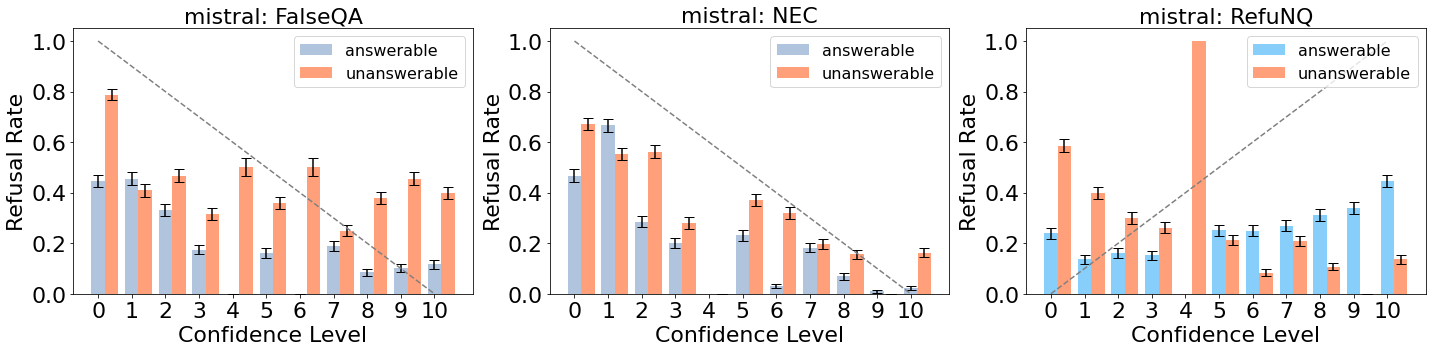

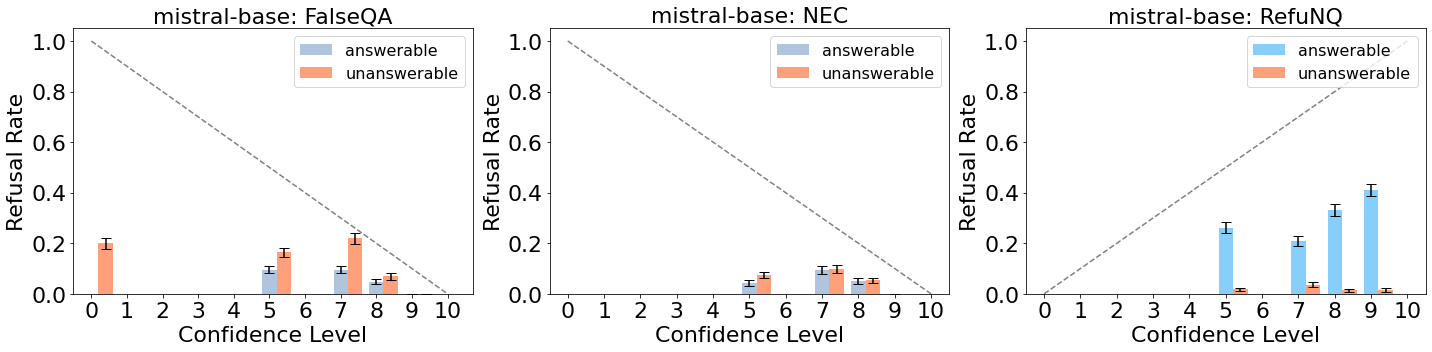

In [14]:
model_list = [
    "mistral",
    "mistral-base"
]

for model_name in model_list:
    generate_refusal_and_accuracy_plot_for_model_name(model_name)